# К статье 2022 года

In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
from rfidam.inventory import RoundModel, SlotModel, estimate_rounds_props, SlotValues
from rfidam.protocol.protocol import Protocol, LinkProps
from rfidam.utils import bcolors, get_err, fmt_err, highlight, pluralize
from rfidam.protocol.symbols import TagEncoding, DR

from tabulate import tabulate
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product

from os.path import join

import pandas as pd

from utility.jupyter_helpers import savefig, get_bw_color, setup_matplotlib

In [3]:
%matplotlib inline
# Настроим Matplotlib: выберем цветовую схему и сделаем шрифты крупнее
setup_matplotlib()

In [4]:
def fmt_header(s):
    return highlight(s, bcolors.OKBLUE)

def fmt_delim(s):
    return highlight(s, bcolors.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

In [19]:
APPROX_EPC = pd.read_csv(join('data', 'nb4_compare_func_epc.csv'))
APPROX_TID = pd.read_csv(join('data', 'nb4_compare_func_tid.csv'))

APPROX_EPC.describe()

,Unnamed: 0,beta,original,approx
count,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.500000,0.000326,0.000324
std,29.011492,0.293045,0.000062,0.000037
min,0.000000,0.000000,0.000302,0.000265
25%,24.750000,0.250000,0.000302,0.000292
50%,49.500000,0.500000,0.000303,0.000322
75%,74.250000,0.750000,0.000309,0.000355
max,99.000000,1.000000,0.000650,0.000391


In [58]:
TARI = 6.25e-6
PROTOCOL_SETTINGS = {
    'tari': TARI,
    'rtcal': TARI * 2.75,
    'trcal': TARI * 3,
    'm': TagEncoding.FM0,
    'dr': DR.DR_643,
    'trext': False,
    'q': 0,
    't_off': 0,
    'n_epcid_bytes': 12,
    'n_data_words': 4
}

LINK_PROPS = {
    'epcid': LinkProps(**PROTOCOL_SETTINGS, use_tid=False),
    'tid': LinkProps(**PROTOCOL_SETTINGS, use_tid=True)
}

PROTOCOLS = {key: Protocol(LINK_PROPS[key]) for key in LINK_PROPS}

BER = np.arange(0, 0.5, 0.01)

In [59]:
ESTIMATED_ROUND_DURATIONS = {key: [] for key in PROTOCOLS}
TQDM_PROTOCOLS = tqdm(PROTOCOLS)

for protocol_name in TQDM_PROTOCOLS:
    
    TQDM_PROTOCOLS.set_description(protocol_name)
    TQDM_BER = tqdm(BER, leave=False)
    protocol = PROTOCOLS[protocol_name]

    for ber in TQDM_BER:
        
        TQDM_BER.set_description(f'BER={ber}')
        estimated_round_durations = []
        
        round_duration, _, _ = estimate_rounds_props(protocol, 1, ber, n_iters=range(2000))
           
        estimated_round_durations.append(round_duration)
        
        # Store results:
        ESTIMATED_ROUND_DURATIONS[protocol_name].append(estimated_round_durations)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

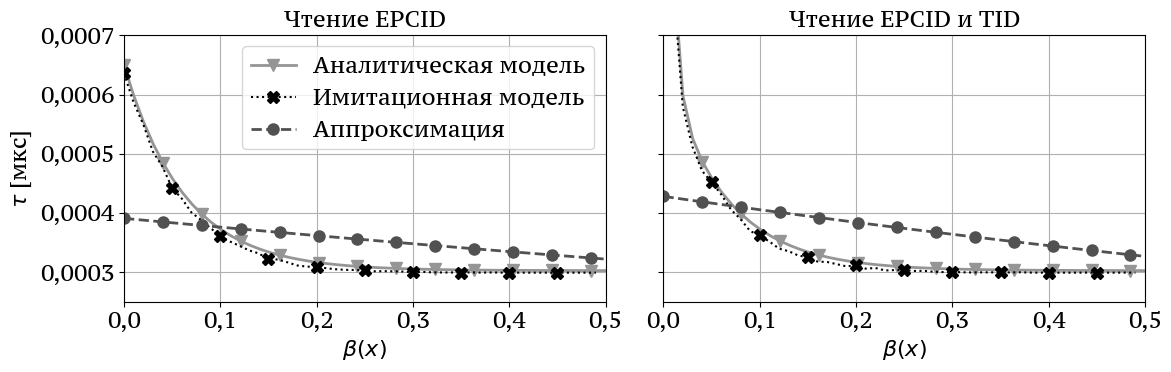

In [95]:
def plot_all():
    fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, sharey=True)
    ax_epc, ax_tid = axes
    
    for ax, data, key in zip(axes, (APPROX_EPC, APPROX_TID), ('epcid', 'tid')):
        ox = data['beta']
        origin = data['original']
        approx = data['approx']
        
        ax.plot(ox, origin, label="Аналитическая модель", 
                color=get_bw_color(0.5), marker='v', markevery=4,
                linewidth=2, markersize=8)
        
        ax.plot(BER, ESTIMATED_ROUND_DURATIONS[key], label='Имитационная модель',
                color=get_bw_color(1.0), linestyle=':', marker='X', markersize=8, markevery=5)
                    
        ax.plot(ox, approx, label="Аппроксимация", 
                color=get_bw_color(0.75), linestyle='--', marker='o', markevery=4,
                linewidth=2, markersize=8)
        
        
    for ax in axes:
        ax.grid()
        ax.set_xlabel(r"$\beta(x)$")
        ax.set_xlim([0, 0.5])
            
    ax_epc.set_ylabel(r'$\tau$ [мкс]')
    ax_epc.set_title("Чтение EPCID")
    ax_epc.legend()
    
    ax_tid.set_ylim([0.00025, 0.0007])    
    ax_tid.set_title("Чтение EPCID и TID")
    
    plt.tight_layout()
    savefig("nb4_round_durations")
        
#     lgd = fig.legend(*ax_epc.get_legend_handles_labels(), loc='lower center', 
#                bbox_to_anchor=(0.5, -0.20), ncol=3)

plot_all()